In [1]:
import torch
import os
import matplotlib.pyplot as plt
from typing import Tuple
from torch.utils.data import DataLoader
import preprocess_dataset
import field_geometry
import losses
from main_network import DecompositionNetwork
import network
import train_eval
import visualize_primitive
import importlib
from typing import Dict
import random
import numpy

torch.cuda.empty_cache()

In [2]:
random.seed(42069)
torch.manual_seed(42069)
numpy.random.seed(42069)

rect_amount = 1
circ_amount = 0
image_size = torch.tensor([64, 64])
data = preprocess_dataset.Rectangle_Dataset(
    rect_amount=rect_amount,  
    circ_amount=circ_amount,
    img_size=image_size,
    mode="hardcoded"
    )
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    data, [train_size, test_size]
)


In [3]:
# Hyperparameters:
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 20
LOAD_MODEL = False
NUM_WORKERS = os.cpu_count()


In [4]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True,
)


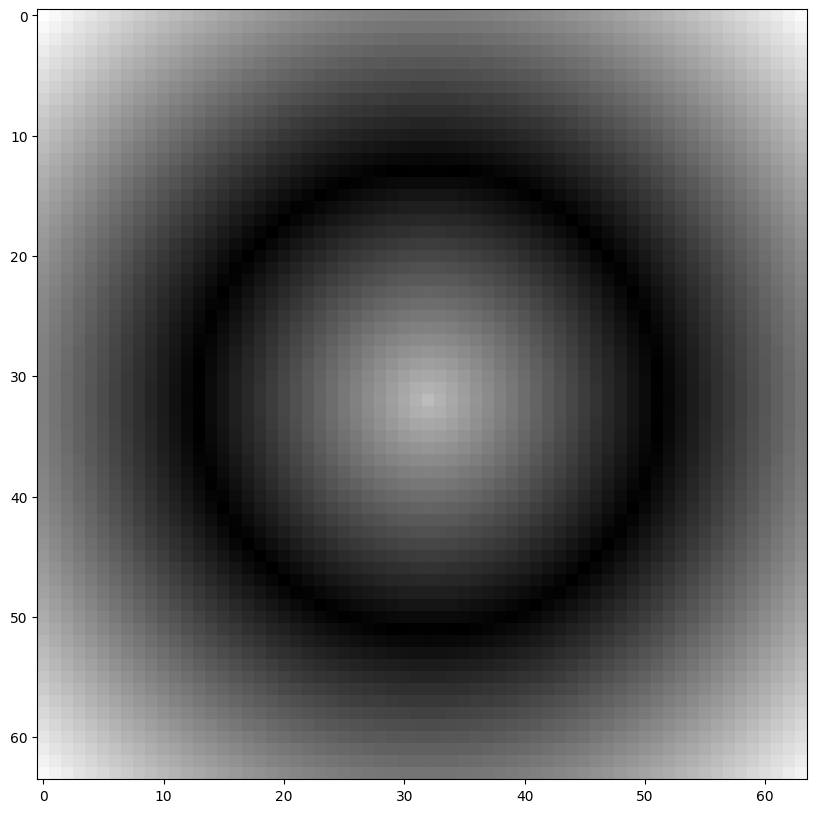

In [5]:
from field_geometry import compute_circle_distance_field, compute_rotated_rectangle_distance_field


r= torch.tensor([
    [
        [0.25, 0.75],
        [0.25, 0.75]
    ]
])

c=torch.tensor([
    [
        [0.5, 0.5, 0.3],
    ]
])

r_field_out = compute_rotated_rectangle_distance_field(r, torch.tensor([0.0]), image_size).squeeze()
r_field_in = compute_rotated_rectangle_distance_field(r, torch.tensor([0.0]), image_size, True).squeeze()

c_field_out = compute_circle_distance_field(c, image_size).squeeze()
c_field_in = compute_circle_distance_field(c, image_size, True).squeeze()

r_field = (r_field_out + r_field_in).unsqueeze(0)
c_field = (c_field_out + c_field_in).unsqueeze(0)

field_all = torch.cat((r_field, c_field), dim=0)
field = field_all.min(dim=0).values

_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(c_field.squeeze(), cmap="gray")




torch.Size([1, 2, 2])
tensor(16.)


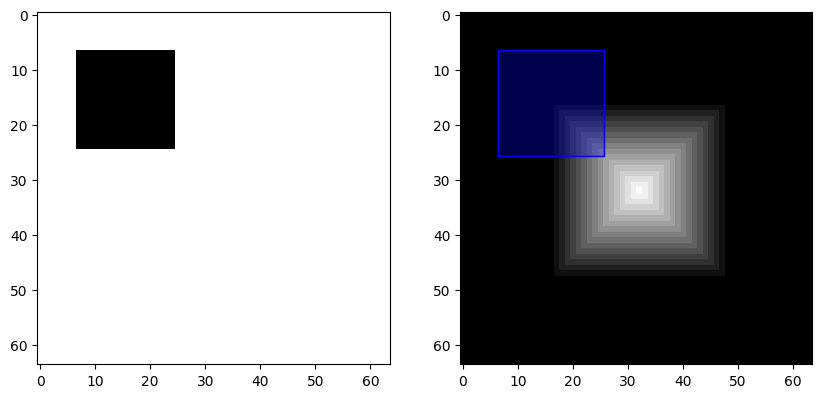

In [6]:
from field_geometry import compute_circle_distance_field, compute_rotated_rectangle_distance_field


_, ax = plt.subplots(1, 2, figsize=(10, 10))

r = torch.tensor([
    [
        [0.1, 0.4],
        [0.1, 0.4]
    ]
])

for mask, field in train_dataloader:
    print(r.shape)
    r_field = (compute_rotated_rectangle_distance_field(r, torch.tensor([0.0]) ,image_size)) == 0
    # r_field = r_field * -1
    ax[0].imshow(r_field.squeeze(), cmap="gray")
    ax[1].imshow(field[0], cmap="gray")
    print(field[0, 32, 32])
    visualize_primitive.plot_rotated_rectangles(ax[1], r, torch.tensor([0]), image_size)
    break

torch.cuda.empty_cache()

In [6]:
torch.cuda.empty_cache()
# triangles and squares are not defined yet

model = network.Model(
    img_size=image_size,
    conv_channels=(1, 12, 6),
    dense_layers=(2048,),
    num_recs=4,
    num_circs=8
)
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


{'Rectangle': 4, 'Circle': 8}


In [7]:
(cov_loss, cons_rect_train_loss, cons_circ_train_loss) = train_eval.train_model(
    NUM_EPOCHS, 
    train_dataloader, 
    train_eval.extract_synthetic_data,
     model, 
     NUM_EPOCHS//2, 
     BATCH_SIZE, 
     optim, 
     DEVICE
)


KeyboardInterrupt



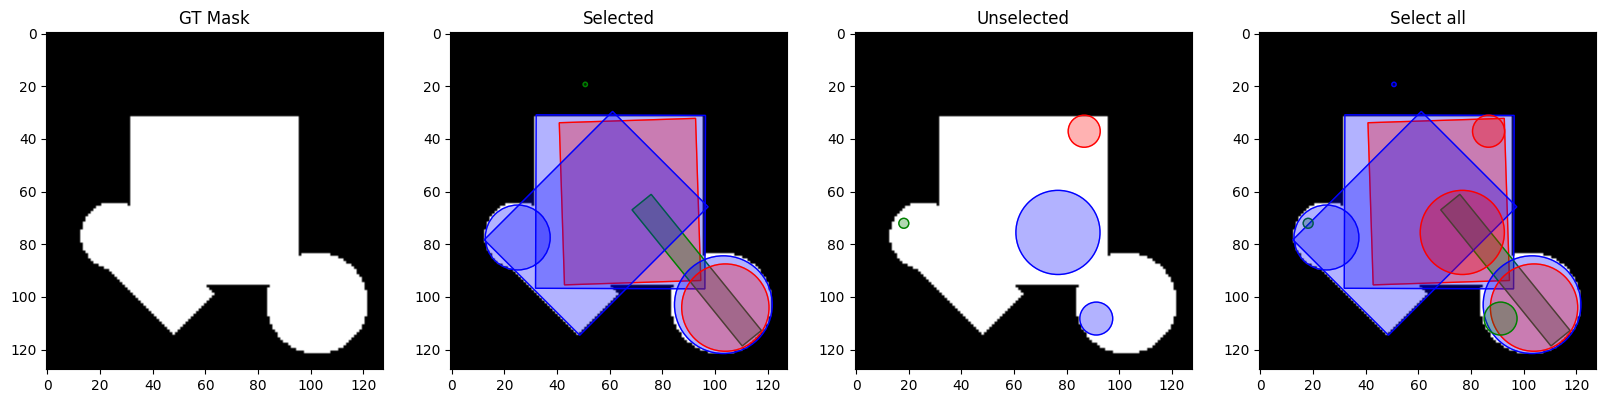

In [ ]:
importlib.reload(visualize_primitive)
importlib.reload(field_geometry)

for mask, dist_field in test_dataloader:

    model.cpu().eval()
    with torch.no_grad():
        r, rp, r_rot, c, cp = train_eval.unpack_model_output(
            model.num_dict, 
            model(mask.float().reshape(-1, 1, *image_size))
            )
        z_rec = (rp > 0.5)
        z_circ = (cp > 0.5)
        torch.set_printoptions(precision=2, sci_mode=False)

    # plot
    _, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,20))
    ax0.imshow(mask[0], cmap="gray")
    ax1.imshow(mask[0], cmap="gray")
    ax2.imshow(mask[0], cmap="gray")
    ax3.imshow(mask[0], cmap="gray")

    visualize_primitive.plot_rotated_rectangles(ax1, r[0, z_rec[0]], r_rot[0, z_rec[0]], mask[0].size())
    visualize_primitive.plot_rotated_rectangles(ax2, r[0, ~z_rec[0]], r_rot[0, ~z_rec[0]],  mask[0].size())
    visualize_primitive.plot_rotated_rectangles(ax3, r[0], r_rot[0], mask[0].size())
    visualize_primitive.plot_circles(ax1, c[0, z_circ[0]], mask[0].size())
    visualize_primitive.plot_circles(ax2, c[0, ~z_circ[0]], mask[0].size())
    visualize_primitive.plot_circles(ax3, c[0], mask[0].size())
    ax0.set(title="GT Mask")
    ax1.set(title="Selected")
    ax2.set(title="Unselected")
    ax3.set(title="Select all")
    break

In [ ]:
import importlib

importlib.reload(train_eval)


IoU_list = []
for mask, dist_field in test_dataloader:
    mask = mask.unsqueeze(1)

    model.cpu().eval()
    with torch.no_grad():
        r, rp, r_rot, c, cp = train_eval.unpack_model_output(
            model.num_dict, 
            model(mask.float().reshape(-1, 1, *image_size))
            )


    IoU_score = train_eval.IoU(r, r_rot, rp, c, cp, 0.5, mask, device="cpu", mode="batch")
    IoU_list.append(IoU_score)

print(sum(IoU_list) / len(IoU_list))


NameError: name 'dist_threshold' is not defined

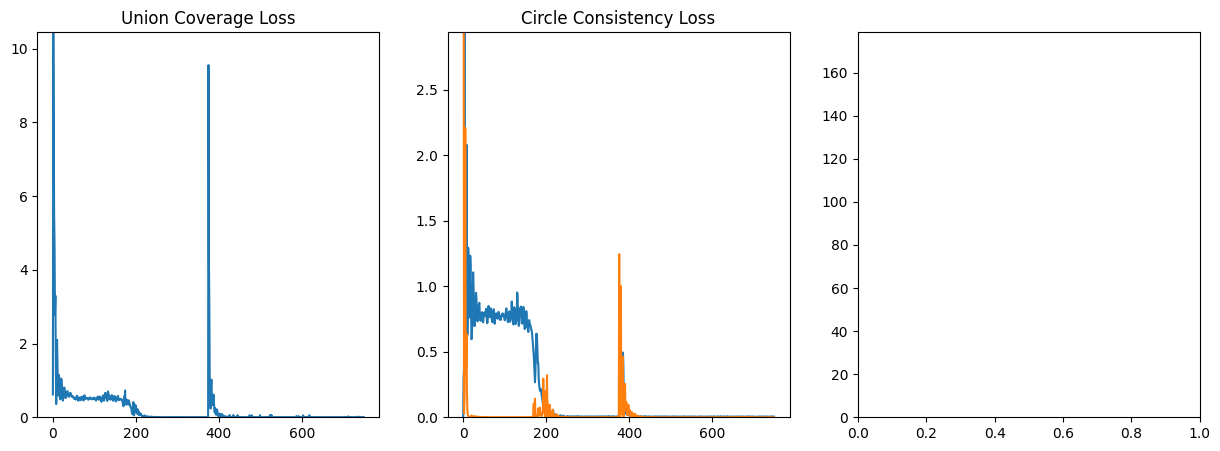

In [ ]:
#(cov_loss, cons_rect_train_loss, cons_circ_train_loss)
_, ax = plt.subplots(1, 3, figsize=(15, 5))
cov_loss_stacked = torch.tensor([cov_loss]).flatten()
cons_loss_rect_stacked = torch.tensor([cons_rect_train_loss]).flatten()
cons_loss_circ_stacked = torch.tensor([cons_circ_train_loss]).flatten()


# ax[0].set_ylim([0, cov_loss_stacked.max()])
ax[0].set_ylim([0, cov_loss_stacked.max()])
ax[1].set_ylim([0, cons_loss_rect_stacked.max()])
ax[2].set_ylim([0, cons_loss_circ_stacked.max()])

# ax[3].set_ylim([0, intersect_loss_stacked.max()])
ax[0].set_title("Union Coverage Loss")
ax[0].plot(cov_loss_stacked)
ax[1].set_title("Rectangle Consistency Loss")
ax[1].plot(cons_loss_rect_stacked)
ax[1].set_title("Circle Consistency Loss")
ax[1].plot(cons_loss_circ_stacked)

plt.show()


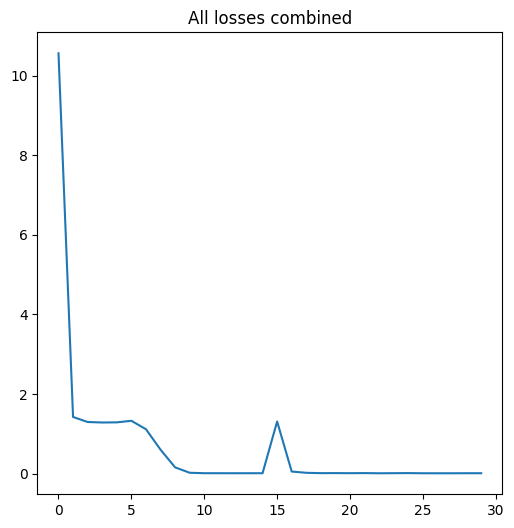

In [ ]:
mean_losses = []
for union_cov, rect_cons, circ_cons in zip(cov_loss, cons_rect_train_loss, cons_circ_train_loss):
    mean_losses.append(
        (
            sum(union_cov) / len(union_cov) 
            + sum(rect_cons) / len(rect_cons) 
            + sum(circ_cons) / len(circ_cons)
        )
    )
mean_losses = torch.stack(mean_losses).detach().cpu()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("All losses combined")
ax.plot(mean_losses)
plt.show()
